# Approximation of the kernel matrix.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the quality of the approximation to the kernel matrix using random features of different types (RBF, Matérn) and Nystöm features.

Note that even the best results for classification need not be obtained by the method that gives the best approximation to the kernel matrix. The reason is that the approximation can have a regularization effect that may improve the accuracy of the predictions on the test set.

In [1]:
%load_ext autoreload
%autoreload 2

## Load necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import datasets
from sklearn.kernel_approximation import RBFSampler
from sklearn.gaussian_process.kernels import Matern
import kernel_approximation as ka


### RBF Kernel approximations

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


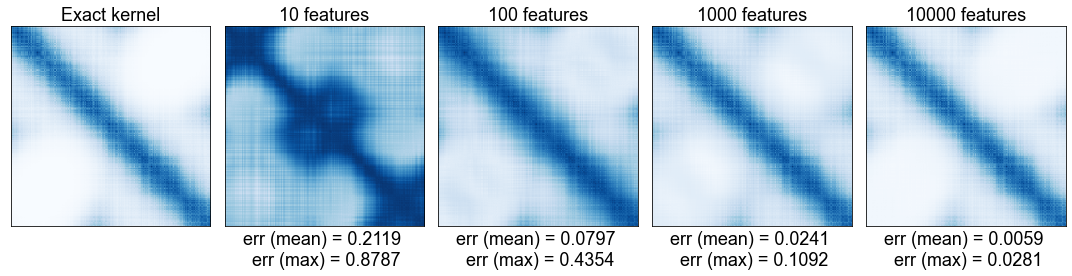

In [2]:
## Generate data
# 3-D data
n_instances = 1000
X, t = datasets.make_s_curve(n_instances, noise=0.1)
X = X[np.argsort(t)]

# Reshape if necessary
if (X.ndim == 1):
    X = X[:, np.newaxis]
    
# RBF kernel parameters 
sigma = 1.0
gamma = 1.0 / (2.0 * sigma**2)

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

## Create an instance of the random features object
rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)

## Plot the approximation to the kernel matrix
n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    rbf_sampler,
    n_random_features
)

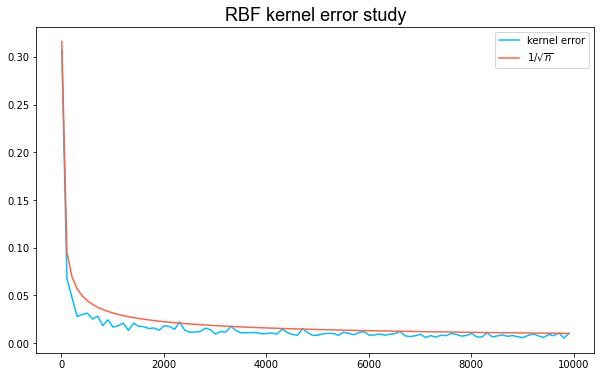

In [3]:
# Create the possible number of features and round them to ints
n_features =  np.arange(10, 10000, 100)

ka.plot_kernel_error(
    X, 
    kernel, 
    rbf_sampler,
    n_features,
    kernel_name='RBF'
)

plt.plot(n_features, 1.0/np.sqrt(n_features),
         color='tomato', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

### Matern Kernel approximations

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


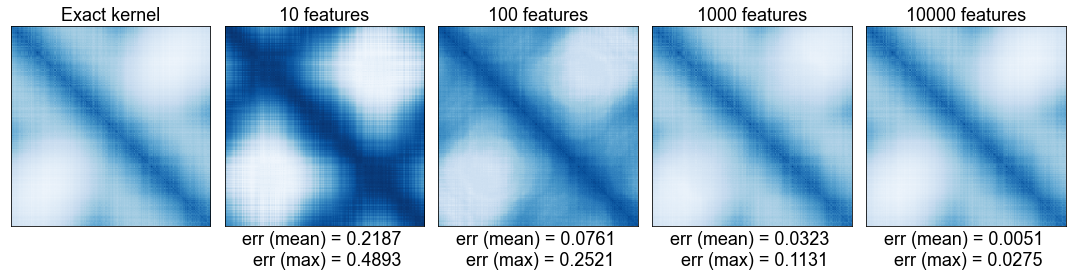

In [4]:
length_scale = 3.0
nu = 0.5

kernel_matern = Matern(length_scale=length_scale, nu=nu) 

def kernel(X, Y):
    return kernel_matern(X, Y)

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)    

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    matern_sampler,
    n_random_features
)

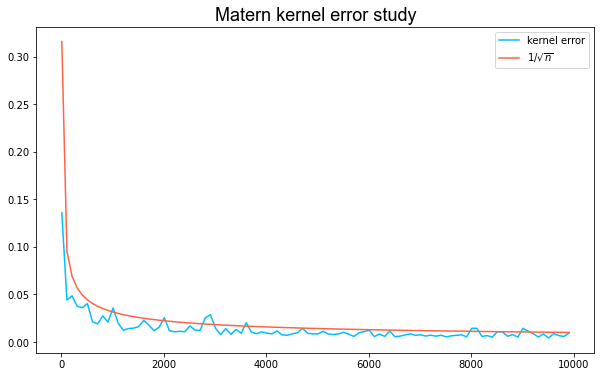

In [5]:
# Create the possible number of features and round them to ints
n_features =  np.arange(10, 10000, 100)

ka.plot_kernel_error(
    X, 
    kernel, 
    matern_sampler,
    n_features,
    kernel_name='Matern'
)

plt.plot(n_features, 1.0/np.sqrt(n_features),
         color='tomato', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

### Nystroem Kernel approximations

# of features =  10
# of features =  100
# of features =  1000


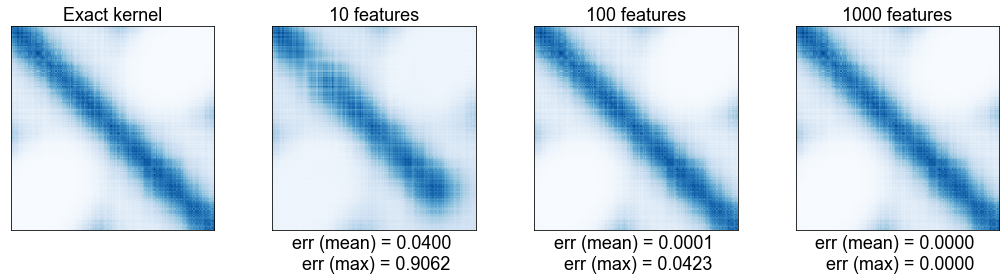

In [6]:
# Kernel parameters 
sigma = 1.0
gamma = 1.0 / (2.0 * sigma**2)

# Kernel matrix

def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

nystroem_sampler = ka.NystroemFeaturesSampler(kernel)

n_nystroem_features = [10, 100, 1000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    nystroem_sampler,
    n_nystroem_features
)

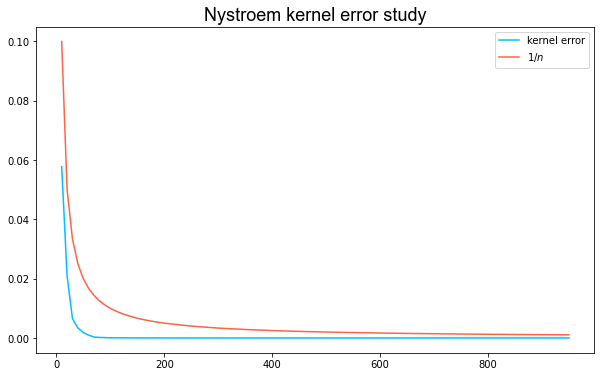

In [7]:
# Create the possible number of features and round them to ints
n_features = np.concatenate((
    np.arange(10, 200, 10),
    np.arange(200, 1000, 50)
))

ka.plot_kernel_error(
    X, 
    kernel, 
    nystroem_sampler,
    n_features,
    kernel_name='Nystroem'
)

plt.plot(n_features, 1.0/n_features,
         color='tomato', label=r"$1/n$")
plt.legend()
plt.show()

## Exercises
1. Implement the incomplete methods in *kernel_approximation.py*
2. Comment on the values of the error for the different approximations, and their dependence with the number of sampled features.
3. (Extra point) Determine de dependence of the mean error with the number of features for the different random feature models. Provide an explanation of this behavior.